In [1]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm, trange
from matplotlib import pyplot as plt

from micro_price_trading import Preprocess, TwoAssetSimulation
from micro_price_trading.config import TWENTY_SECOND_DAY, DATA_PATH

In [2]:
raw = Preprocess('Test_TBT_TBF_data.csv')
data = raw.process()

In [3]:
def base_twap(t, asset, iters):
    sim = TwoAssetSimulation(data, steps=TWENTY_SECOND_DAY, seed=0)
    shares = 1 if asset == 2 else 2
    shares1 = list()
    shares2 = list()
    prices = list()
    for _ in trange(iters):
        shares1.append([0])
        shares2.append([0])
        prices.append([])
        for idx in range(0, TWENTY_SECOND_DAY, t):
            if asset == 1:
                shares1[-1].append(shares1[-1][-1]+shares)
                shares2[-1].append(0)
            else:
                shares2[-1].append(shares2[-1][-1]+shares)
                shares1[-1].append(0)
            prices[-1].append(sim.states[f'mid_{asset}'][idx])
        sim._reset_simulation()
    return np.array(prices), pd.DataFrame({'asset1': shares1[-1], 'asset2': shares2[-1]})

In [4]:
def random_twap(t, iters, weights=(0.5, 0.5)):
    sim = TwoAssetSimulation(data, steps=TWENTY_SECOND_DAY, seed=0)
    np.random.seed(0)
    shares1 = list()
    shares2 = list()
    buy1 = list()
    buy2 = list()
    prices1 = list()
    prices2 = list()
    for _ in trange(iters):
        shares1.append([0])
        shares2.append([0])
        prices1.append([])
        prices2.append([])
        buy1.append([])
        buy2.append([])
        all_choices = np.random.choice([1, 2], p=weights, size=TWENTY_SECOND_DAY//t)
        for asset, idx in zip(all_choices, range(0, TWENTY_SECOND_DAY, t)):
            shares = 1 if asset == 2 else 2
            if asset == 1:
                shares1[-1].append(shares1[-1][-1]+shares)
                shares2[-1].append(shares2[-1][-1])
                prices1[-1].append(sim.states[f'mid_{asset}'][idx])
                buy1[-1].append(shares)
            else:
                shares2[-1].append(shares2[-1][-1]+shares)
                shares1[-1].append(shares1[-1][-1])
                prices2[-1].append(sim.states[f'mid_{asset}'][idx])
                buy2[-1].append(shares)
        sim._reset_simulation()
    return prices1, prices2, buy1, buy2, np.array(shares1), np.array(shares2)

In [22]:
prices1, shares1 = base_twap(3, 1, 200)

In [23]:
prices2, shares2 = base_twap(3, 2, 200)

In [24]:
p1, p2, b1, b2, s1, s2 = random_twap(3, 200, (0.5, 0.5))

In [25]:
p1_means = [np.mean(l) for l in p1]
p2_means = [np.mean(l) for l in p2]

In [26]:
avg1 = (p1_means-prices1.mean(axis=1))*s1[:, -1]

In [27]:
avg2 = (p2_means-prices2.mean(axis=1))*s2[:, -1]

In [28]:
diff = avg1 + avg2

In [29]:
(diff.mean() - 1.96 * diff.std()/np.sqrt(len(diff)), diff.mean() + 1.96 * diff.std()/np.sqrt(len(diff)))

(-0.1271232629539776, 0.19159480141548427)

In [13]:
def optimal_twap(t, iters, q_vals):
    sim = TwoAssetSimulation(data, steps=TWENTY_SECOND_DAY, seed=0)
    shares1 = list()
    shares2 = list()
    buy1 = list()
    buy2 = list()
    prices1 = list()
    prices2 = list()
    for _ in trange(iters):
        shares1.append([0])
        shares2.append([0])
        prices1.append([])
        prices2.append([])
        buy1.append([])
        buy2.append([])
        for idx in range(0, TWENTY_SECOND_DAY, t):
            res_imb_state = sim.states.states[idx]
            qs = q_vals.loc[res_imb_state]
            if qs[0] > qs[1]:
                asset = 1
            else:
                asset = 2
            shares = 1 if asset == 2 else 2
            if asset == 1:
                shares1[-1].append(shares1[-1][-1]+shares)
                shares2[-1].append(shares2[-1][-1])
                prices1[-1].append(sim.states[f'mid_{asset}'][idx])
                buy1[-1].append(shares)
            else:
                shares2[-1].append(shares2[-1][-1]+shares)
                shares1[-1].append(shares1[-1][-1])
                prices2[-1].append(sim.states[f'mid_{asset}'][idx])
                buy2[-1].append(shares)
        sim._reset_simulation()
    return prices1, prices2, buy1, buy2, np.array(shares1), np.array(shares2)

In [14]:
q_values = pd.read_csv(DATA_PATH.joinpath('q_values_9_27.csv'), index_col=0)

In [30]:
op1, op2, ob1, ob2, os1, os2 = optimal_twap(3, 200, q_values)

In [31]:
op1_means = [np.mean(l) for l in op1]
op2_means = [np.mean(l) for l in op2]

In [32]:
oavg1 = (op1_means-prices1.mean(axis=1))*os1[:, -1]

In [33]:
oavg2 = (op2_means-prices2.mean(axis=1))*os2[:, -1]

In [34]:
odiff = oavg1 + oavg2

In [35]:
(odiff.mean() - 1.96 * odiff.std()/np.sqrt(len(odiff)), odiff.mean() + 1.96 * odiff.std()/np.sqrt(len(odiff)))

(-0.2402846161176188, 0.3643223084252672)

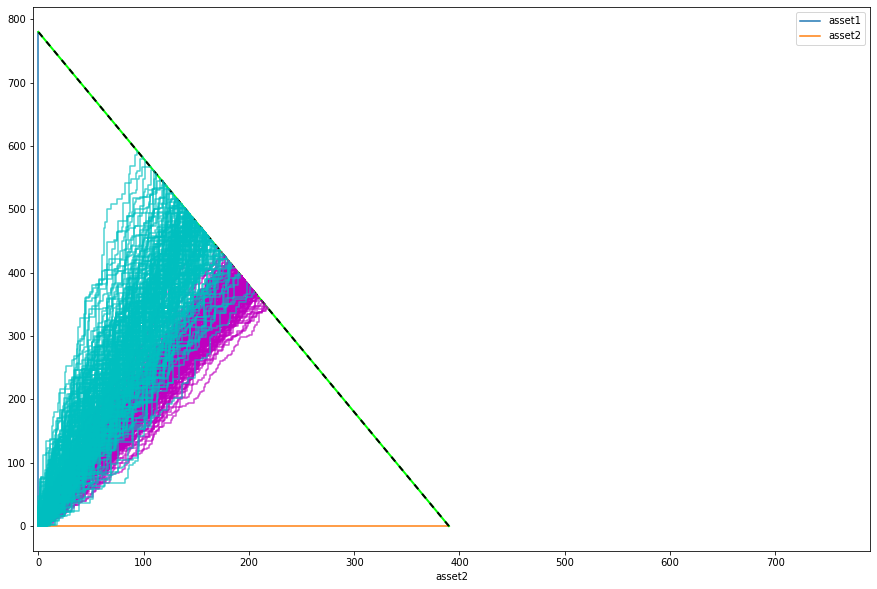

In [36]:
fig, ax = plt.subplots(figsize=(15, 10))
shares1.plot('asset2', 'asset1', kind='line', ax=ax, label='asset1')
shares2.plot('asset2', 'asset1', kind='line', ax=ax, label='asset2')
ax.plot([shares2.asset2.iloc[-1], 0], [0, shares1.asset1.iloc[-1]], 'lime', linewidth=2)
ax.plot([shares2.asset2.iloc[-1], 0], [0, shares1.asset1.iloc[-1]], 'k--', linewidth=2, dashes=(3, 3))
ax.set_xlim(-5, shares1.asset1.max()+10)
for idx in range(s1.shape[0]):
    ax.plot(s2[idx], s1[idx], 'm', alpha=0.7)
for idx in range(os1.shape[0]):
    ax.plot(os2[idx], os1[idx], 'c', alpha=0.7)